In [1]:
!apt update > /dev/null && apt upgrade > /dev/null
!pip install kaggle > /dev/null



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Extracting templates from packages: 100%


In [2]:
import kagglehub
import os

# Download latest version
# path 현재 파일이 다운로드된 경로
path = kagglehub.dataset_download("computingvictor/transactions-fraud-datasets")

os.chdir(path) # 경로를 현재 다운로드된 파일들이 있는 경로로 변경
print(os.getcwd()) # 현재 폴더 경로; 작업 폴더 기준
print(os.listdir(os.getcwd()))

100%|██████████| 348M/348M [00:18<00:00, 20.3MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/computingvictor/transactions-fraud-datasets/versions/1
['users_data.csv', 'mcc_codes.json', 'train_fraud_labels.json', 'cards_data.csv', 'transactions_data.csv']


필요한 부분만 병합 후 남기기

In [13]:
import pandas as pd
import json

with open('train_fraud_labels.json') as f:
    js = json.loads(f.read())
fraud = pd.DataFrame(js)
fraud = fraud.reset_index()
fraud.columns = ["id", "fraud"]

file_path = "transactions_data.csv"
trans = pd.read_csv(file_path)
columns_to_keep = ["id", "amount"]
# 특정 컬럼만 남기기
trans = trans[columns_to_keep]

fraud['id'] = fraud['id'].astype(str)
trans['id'] = trans['id'].astype(str)

merge = pd.merge(fraud, trans, on='id')
columns_to_keep = ["fraud", "amount"]
merge = merge[columns_to_keep]
merge.head(7)

,fraud,amount
0,No,$14.01
1,No,$1.40
2,No,$16.83
3,No,$34.98
4,No,$9.62
5,No,$93.32
6,No,$387.64


In [4]:
merge.dtypes

,0
fraud,object
amount,object


In [14]:
merge['amount'] = merge['amount'].replace({'\$': ''}, regex=True).astype(float)
merge

,fraud,amount
0,No,14.01
1,No,1.40
2,No,16.83
3,No,34.98
4,No,9.62
...,...,...
8914958,No,4.58
8914959,No,4.50
8914960,No,84.77
8914961,No,9.62


In [15]:
merge['fraud'] = merge['fraud'].astype(str)
merge

,fraud,amount
0,No,14.01
1,No,1.40
2,No,16.83
3,No,34.98
4,No,9.62
...,...,...
8914958,No,4.58
8914959,No,4.50
8914960,No,84.77
8914961,No,9.62


In [16]:
print(merge.dtypes)
print(merge['fraud'].unique())
min_value = merge['amount'].min()
max_value = merge['amount'].max()
print(f"최대값: {max_value}")
print(f"최소값: {min_value}")

fraud      object
amount    float64
dtype: object
['No' 'Yes']
최대값: 6613.44
최소값: -500.0


사기 여부를 막대 그래프로 비율표시

<ipython-input-18-7d95dfc73ae7>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = merge.groupby(['amount_group', 'fraud']).size().unstack(fill_value=0)


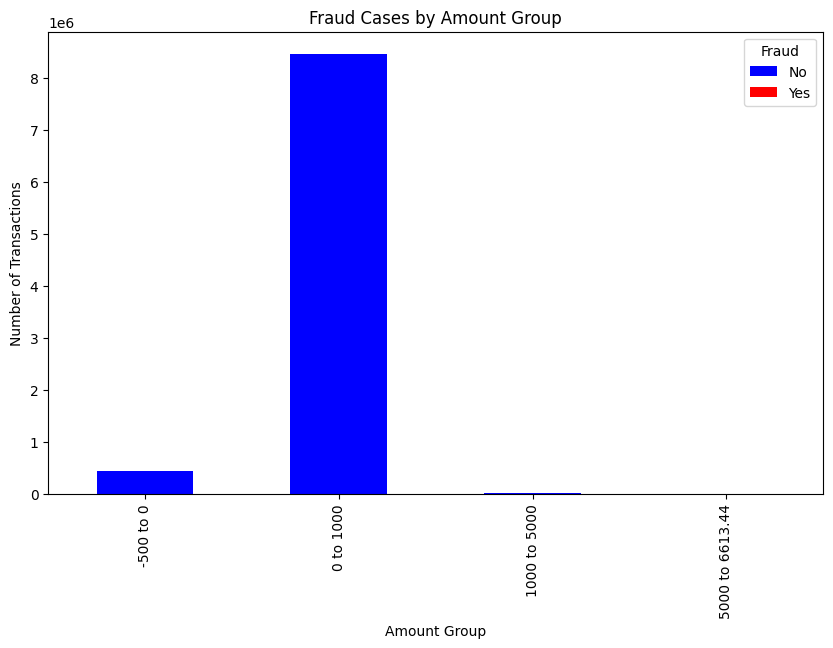

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 금액 구간 설정
# 최소값 -500, 최대값 6613.44에 맞춰 구간 설정
bins = [-500, 0, 1000, 5000, 6613.44]  # 구간 경계
labels = ['-500 to 0', '0 to 1000', '1000 to 5000', '5000 to 6613.44']  # 구간 이름
merge['amount_group'] = pd.cut(merge['amount'], bins=bins, labels=labels, right=False)

# 2. 구간별 사기 거래 빈도 계산
grouped = merge.groupby(['amount_group', 'fraud']).size().unstack(fill_value=0)

# 3. 시각화 (구간별 사기 거래 빈도 시각화)
grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color=['blue', 'red'])
plt.title('Fraud Cases by Amount Group')
plt.xlabel('Amount Group')
plt.ylabel('Number of Transactions')
plt.legend(title='Fraud', labels=['No', 'Yes'])
plt.show()

<ipython-input-17-04ad183aec9b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_data['amount_group'] = pd.cut(fraud_data['amount'], bins=bins, labels=labels, right=False)
<ipython-input-17-04ad183aec9b>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = fraud_data.groupby(['amount_group']).size()


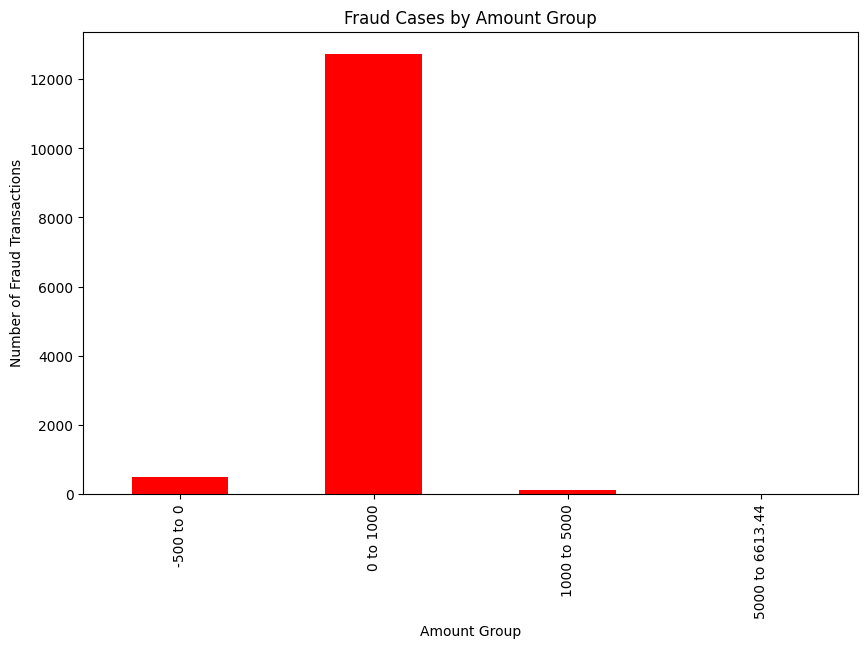

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 사기 거래만 필터링
fraud_data = merge[merge['fraud'] == 'Yes']

# 2. 금액 구간 설정
# 최소값 -500, 최대값 6613.44에 맞춰 구간 설정
bins = [-500, 0, 1000, 5000, 6613.44]  # 구간 경계
labels = ['-500 to 0', '0 to 1000', '1000 to 5000', '5000 to 6613.44']  # 구간 이름
fraud_data['amount_group'] = pd.cut(fraud_data['amount'], bins=bins, labels=labels, right=False)

# 3. 구간별 사기 거래 빈도 계산
grouped = fraud_data.groupby(['amount_group']).size()

# 4. 시각화 (구간별 사기 거래 빈도 시각화)
grouped.plot(kind='bar', figsize=(10, 6), color='red')
plt.title('Fraud Cases by Amount Group')
plt.xlabel('Amount Group')
plt.ylabel('Number of Fraud Transactions')
plt.show()

<ipython-input-19-07f3bfd690a0>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = merge.groupby(['amount_group', 'fraud']).size().unstack(fill_value=0)


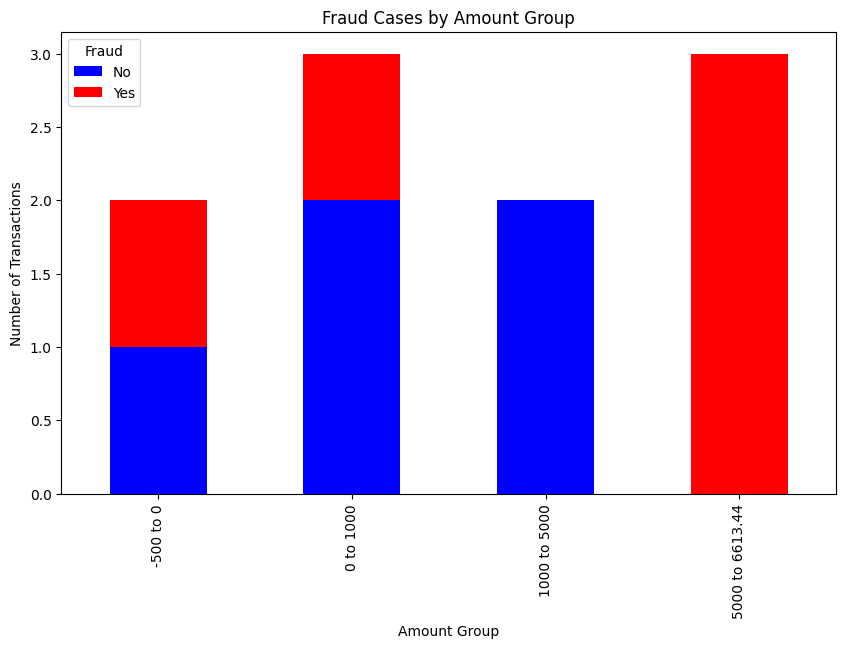

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 예시 데이터프레임 (merge라는 이름의 데이터프레임을 사용한다고 가정)
# 실제 merge 데이터프레임에 맞게 사용하세요.
data = {
    'amount': [100.0, 200.0, 300.0, 1500.0, 5000.0, -100.0, -300.0, 3500.0, 6000.0, 6600.0],
    'fraud': ['No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes']
}
merge = pd.DataFrame(data)

# 1. 금액 구간 설정
# 최소값 -500, 최대값 6613.44에 맞춰 구간 설정
bins = [-500, 0, 1000, 5000, 6613.44]  # 구간 경계
labels = ['-500 to 0', '0 to 1000', '1000 to 5000', '5000 to 6613.44']  # 구간 이름
merge['amount_group'] = pd.cut(merge['amount'], bins=bins, labels=labels, right=False)

# 2. 구간별 사기 거래 빈도 계산
grouped = merge.groupby(['amount_group', 'fraud']).size().unstack(fill_value=0)

# 3. 시각화 (구간별 사기 거래 빈도 시각화)
grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color=['blue', 'red'])
plt.title('Fraud Cases by Amount Group')
plt.xlabel('Amount Group')
plt.ylabel('Number of Transactions')
plt.legend(title='Fraud', labels=['No', 'Yes'])
plt.show()